In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from trialblazer.models import (
    get_morgan2,
    compute_2Drdkit,
    MLP_simulation_test,
    MLP_cv,
    MLP_decision_threshold_optimization,
    RF_cv,
    feature_selection
)

[16:29:34] Initializing Normalizer


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
Training_data = pd.read_csv("../Data/Training_data_withoutInfo.csv", sep='|')

# Descriptors

## Predicted bioactivity fingerprints (PBFPs)

In [13]:
Target_features = pd.read_csv('../Data/Training_target_features.csv')

In [14]:
active_targets_merged_forlist = Target_features.drop(columns=['SmilesForDropDu'])
targets_list = list(active_targets_merged_forlist.columns)
print(len(targets_list))

777


In [15]:
Training_data = Training_data.merge(Target_features, how='left',on='SmilesForDropDu')
Training_data[targets_list].isna().any().sum()

np.int64(0)

## Morgan2 fingerprints (M2FPs)

In [ ]:
Training_data.Molecule = Training_data.SmilesForDropDu.apply(Chem.MolFromSmiles)
Training_data['fp'] = Training_data.Molecule.apply(get_morgan2)
morgan2_cols = ['morgan2_b'+ str(i) for i in list(range(2048))]
Training_data[morgan2_cols] = Training_data['fp'].to_list()

## Physicochemical descriptors (PCD)

In [19]:
descriptors_list = [x[0] for x in Descriptors._descList]
print(len(descriptors_list))

217


In [22]:
Training_data.Molecule = Training_data.SmilesForDropDu.apply(Chem.MolFromSmiles)
Training_data['desc'] = Training_data.Molecule.apply(compute_2Drdkit)

In [16]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
desc_cols = list(calc.GetDescriptorNames())
Training_data[desc_cols] = Training_data.desc.to_list()
Training_data.drop("desc",axis=1,inplace=True)

In [17]:
Training_data[desc_cols].dropna(inplace=True)
Training_data[desc_cols].isnull().values.any()

np.True_

In [18]:
Training_data[desc_cols][Training_data[desc_cols].isna().any(axis=1)] # somehow dropna didn't remove this.

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
1283,10.087087,10.087087,0.548681,-0.889583,0.619832,13.111111,196.108,185.02,196.9955,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
Training_data.iloc[1283,:]

inchi_noStereo        InChI=1S/C5H11NO2Se/c1-9-3-2-4(6)5(7)8/h4H,2-3...
preprocessedSmiles                                C[Se]CC[C@H](N)C(=O)O
id                                                          Benign-1309
conID                                                              1309
tautomerizedSmiles                                    C[Se]CCC(N)C(=O)O
                                            ...                        
fr_thiazole                                                         0.0
fr_thiocyan                                                         0.0
fr_thiophene                                                        0.0
fr_unbrch_alkane                                                    0.0
fr_urea                                                             0.0
Name: 1283, Length: 3051, dtype: object

In [21]:
Training_data.drop(labels=1283, axis=0,inplace=True)
Training_data.reset_index(inplace=True)

# 10-fold cross validation

## model based on 208 physicochemical descriptors

In [ ]:
X = Training_data[desc_cols]
y = Training_data.Mark

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

MLP

In [ ]:
MLP_cv(X_scaled,y)

RF

In [ ]:
RF_cv(X_scaled,y)

## model based on M2FPs

In [31]:
X = Training_data[morgan2_cols]
y = Training_data.Mark

MLP

In [ ]:
opt_threshold_ap, opt_threshold_mean = MLP_decision_threshold_optimization(X,y,800) # decision threshold_optimization

In [ ]:
MLP_cv(np.array(X),y,800,0.10338700489734302)

RF

In [ ]:
RF_cv(np.array(X),y,800)

## model based on M2FPs+PBFPs

In [17]:
M2FPs_PBFPs =  morgan2_cols + targets_list
len(M2FPs_PBFPs)

2825

In [18]:
X = Training_data[M2FPs_PBFPs]
y = Training_data.Mark

Default_MLP

In [ ]:
MLP_cv(np.array(X),y)

Optimized_MLP

In [38]:
opt_threshold_ap, opt_threshold_mean = MLP_decision_threshold_optimization(X,y,900) # decision threshold_optimization

Matthews Correlation Coefficient = 0.44, 0.12
Balanced Accuracy score = 0.78, 0.07
recall = 0.76, 0.09
precision = 0.39, 0.09


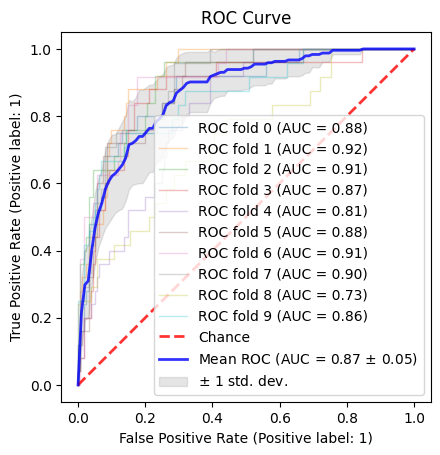

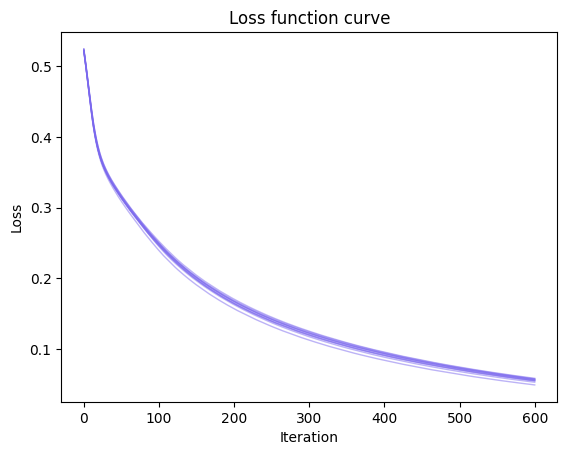

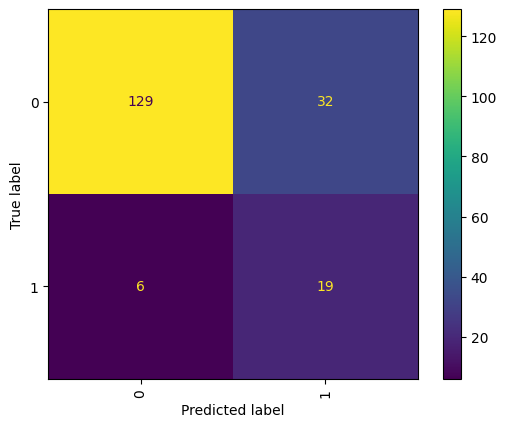

In [19]:
MLP_cv(np.array(X),y, 900, 0.06264154114736771)

RF

In [ ]:
RF_cv(np.array(X),y)

# Simulation tests

In [20]:
X = Training_data[M2FPs_PBFPs]
selector = SelectKBest(f_classif, k=900)
X_new = selector.fit_transform(X, y)

In [21]:
k_fold_mccs = []
for iter in tqdm(range(1, 10001)): 
    k_fold_mccs.append(MLP_simulation_test(X_new,y))

100%|██████████| 10000/10000 [01:26<00:00, 115.53it/s]


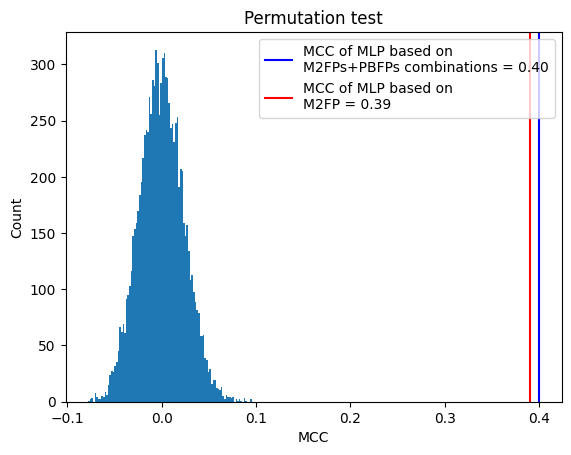

In [26]:
plt.hist(k_fold_mccs, bins=100);
plt.xlabel('MCC', fontsize = 10) 
plt.ylabel('Count',fontsize = 10) 
plt.title('Permutation test')
plt.axvline(x = 0.40, color = 'b',label = 'MCC of MLP based on\nM2FPs+PBFPs combinations = 0.40')
plt.axvline(x = 0.39, color = 'r',label = 'MCC of MLP based on\nM2FP = 0.39')
plt.legend(loc='upper right')

# Hyperparameter optimization

MLP

In [ ]:
selector = SelectKBest(f_classif, k=900)
X_new = selector.fit_transform(X, y)
param_grid = {
    'hidden_layer_sizes':[(10,),(20,),(30,),(40,),(50,),(60,),(70,),(80,),(90,),(100,)],
    'learning_rate_init':[0.0001,0.001,0.01,0.1],
    'random_state':[42],
    'max_iter':[200, 400, 600, 800]
    }
MLP = MLPClassifier()
grid_search = GridSearchCV(
    estimator = MLP, 
    param_grid = param_grid, 
    scoring='roc_auc',
    cv = 10)
grid_search.fit(X_new, y)
grid_search.best_params_

RF

In [ ]:
selector = SelectKBest(f_classif, k='all')
X_new = selector.fit_transform(X, y)
param_dist = {
    'n_estimators': [10, 50, 100, 200],               
    'max_features': ['auto', 'sqrt', 'log2'],          
    'max_depth': [None, 10, 20, 30, 40, 50],           
    'min_samples_split': [2, 5, 10],                  
    'min_samples_leaf': [1, 2, 4],                    
    'bootstrap': [True, False],                       
    'class_weight':['balanced']
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(
    estimator = rf, 
    param_grid = param_dist, 
    scoring='roc_auc',
    cv = 10)
grid_search.fit(X_new, y)
grid_search.best_params_

# Feature selecttion (K value optimization)

Example of model based on M2FPs+PBFPs features

In [ ]:
ANOVA_K_list = ['500','550','600','650','700','750','800','850','900','950','1000']
feature_selection(X, y, M2FPs_PBFPs,'M2FPs+PBFPs', ANOVA_K_list) 